# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302206
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:**
因为w随机初始化，所以每个类计算的得分都是相同的，经过softmax之后的概率都是一样的，而这是一个10分类的问题，所以每个类的概率都是0.1，经过交叉熵得到的loss就是 -log(0.1)


In [6]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 4.290835 analytic: 4.290835, relative error: 1.705527e-09
numerical: -0.872521 analytic: -0.872521, relative error: 1.519383e-08
numerical: 3.234726 analytic: 3.234726, relative error: 1.954253e-08
numerical: 1.485484 analytic: 1.485484, relative error: 8.017981e-10
numerical: -0.929303 analytic: -0.929303, relative error: 3.973543e-08
numerical: -4.381870 analytic: -4.381870, relative error: 1.811912e-08
numerical: 2.461152 analytic: 2.461152, relative error: 3.996641e-08
numerical: 0.416943 analytic: 0.416943, relative error: 1.204979e-07
numerical: 1.469489 analytic: 1.469489, relative error: 4.640853e-08
numerical: -1.689912 analytic: -1.689912, relative error: 2.311380e-08
numerical: -0.623944 analytic: -0.623944, relative error: 8.446309e-08
numerical: -2.412011 analytic: -2.412011, relative error: 6.278172e-09
numerical: 1.064215 analytic: 1.064215, relative error: 1.837684e-08
numerical: 0.400143 analytic: 0.400143, relative error: 1.785304e-08
numerical: 1.726260 an

In [14]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()

loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.302206e+00 computed in 0.127924s
(500,)
1151.103026252948
vectorized loss: 2.302206e+00 computed in 0.004998s
Loss difference: 0.000000
Gradient difference: 0.000000


In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from copy import deepcopy
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e3, 5e3, 7e3]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, reg, 1500, 128)
        train_pred = softmax.predict(X_train)
        train_acc = np.mean(train_pred == y_train)
        val_pred = softmax.predict(X_val)
        val_acc = np.mean(val_pred == y_val)
        results[(lr, reg)] = [train_acc, val_acc]
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = deepcopy(softmax)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(128,)
699.9724311595184
(128,)
853.8170712102595
(128,)
674.0230113110122
(128,)
817.986422096787
(128,)
783.6123484161812
(128,)
787.8892514217862
(128,)
727.319661945779
(128,)
695.3433243230388
(128,)
716.7954803381896
(128,)
726.752419211536
(128,)
675.7674030386213
(128,)
749.5927174131318
(128,)
631.9858064927703
(128,)
712.7327730803612
(128,)
680.1625496478781
(128,)
679.854831183133
(128,)
707.2258327643481
(128,)
770.9613449547089
(128,)
613.09925872536
(128,)
687.0691009220229
(128,)
692.0218056373569
(128,)
605.7046738594295
(128,)
688.7523936668565
(128,)
715.5449857568233
(128,)
679.5445437135631
(128,)
715.2458831736701
(128,)
655.1469135062216
(128,)
660.3381602166214
(128,)
613.2730666639706
(128,)
671.1882974594494
(128,)
679.2040410351582
(128,)
621.2799079692128
(128,)
620.755443938557
(128,)
739.7088874425169
(128,)
694.249947360245
(128,)
585.0198661694608
(128,)
690.2969731078123
(128,)
685.2325951596016
(128,)
608.9730225827407
(128,)
628.0972148800008
(128,)
5

(128,)
352.233851419099
(128,)
401.18854700589895
(128,)
365.01810734055664
(128,)
409.70937103617604
(128,)
361.3556956919972
(128,)
385.23220899280034
(128,)
351.34573625656776
(128,)
360.78184838077516
(128,)
387.1121619191878
(128,)
374.57634651916857
(128,)
377.3255458983584
(128,)
353.5356817808717
(128,)
373.58542887834216
(128,)
359.1589497671688
(128,)
366.0986220439694
(128,)
378.7599147275465
(128,)
402.1306974003151
(128,)
338.08415479094333
(128,)
404.5301860127407
(128,)
371.4356154119795
(128,)
400.6773827449555
(128,)
377.36246599503806
(128,)
354.9490875354646
(128,)
351.2875751036849
(128,)
361.3527809986821
(128,)
343.9147311608259
(128,)
386.4586329515249
(128,)
397.02320720906914
(128,)
356.7627779188232
(128,)
346.3836942921087
(128,)
390.8786533091135
(128,)
377.3697271426008
(128,)
305.46523809756695
(128,)
345.3954877570692
(128,)
346.5421143117676
(128,)
351.1052716047287
(128,)
361.41442186639046
(128,)
324.9756615632864
(128,)
378.43074851709184
(128,)
376.2

(128,)
326.62323005547285
(128,)
318.14430531164453
(128,)
280.50447585570043
(128,)
312.45726080761494
(128,)
310.01513776819
(128,)
332.2777292710217
(128,)
314.43534078473715
(128,)
299.76713844891844
(128,)
293.9718607688522
(128,)
347.330324299367
(128,)
353.6884995133221
(128,)
279.2684904791564
(128,)
305.22951721683194
(128,)
307.78566867545635
(128,)
324.39833385978216
(128,)
319.81115658385045
(128,)
298.48346037433043
(128,)
336.56143204846404
(128,)
294.7517825866829
(128,)
298.59621838526505
(128,)
344.8428193572904
(128,)
297.8880824316426
(128,)
285.4919654282229
(128,)
292.4672732438216
(128,)
319.47145566051086
(128,)
286.9286509999803
(128,)
323.2952443824752
(128,)
355.5686230303436
(128,)
286.95352883675724
(128,)
294.20269739491994
(128,)
331.76253009596763
(128,)
307.06914979432884
(128,)
283.31884472118645
(128,)
333.78369863885627
(128,)
294.1272903770171
(128,)
272.97764494102114
(128,)
310.8805217463417
(128,)
311.8006945843373
(128,)
306.74745979449256
(128,)

(128,)
258.2814378959158
(128,)
272.5245572018102
(128,)
294.38870659752246
(128,)
284.5678195085844
(128,)
270.3134078013587
(128,)
282.7176192646366
(128,)
275.8209116580154
(128,)
249.456703882868
(128,)
301.03131872932556
(128,)
271.8625543179131
(128,)
288.9895617383769
(128,)
273.93114962304475
(128,)
288.95331158833415
(128,)
283.1034746022223
(128,)
279.56932130664154
(128,)
274.1236604466005
(128,)
294.7557054675603
(128,)
279.66832563100803
(128,)
292.6070292978351
(128,)
251.82429800887562
(128,)
283.16806820520674
(128,)
257.77246948844834
(128,)
258.62373325963483
(128,)
283.2652451804763
(128,)
273.6559076776841
(128,)
280.2352088080914
(128,)
301.71121923486294
(128,)
263.6380300240036
(128,)
283.6578888861418
(128,)
305.0328278516853
(128,)
271.84494028903106
(128,)
280.75321714111885
(128,)
252.49933187933297
(128,)
259.0682111836959
(128,)
295.86189466726944
(128,)
276.2631290938699
(128,)
273.68329403146606
(128,)
288.3766941486044
(128,)
251.36534671423914
(128,)
25

(128,)
261.8233397024224
(128,)
246.50538761952942
(128,)
264.71676904937294
(128,)
246.2782232821982
(128,)
274.7000490456366
(128,)
271.8118890850787
(128,)
272.3491833707033
(128,)
264.91671326424165
(128,)
258.9938936585543
(128,)
275.73100196397786
(128,)
267.5356867808375
(128,)
249.52742159401382
(128,)
256.53853290778125
(128,)
263.9017972330943
(128,)
267.0668006265779
(128,)
293.63535557484283
(128,)
263.04204948518543
(128,)
247.20347959910998
(128,)
259.90706785077305
(128,)
249.0498504908498
(128,)
270.4485875239135
(128,)
264.4552445903793
(128,)
261.99128613263554
(128,)
267.41921848889996
(128,)
254.39912366391366
(128,)
262.9592205640149
(128,)
253.97245999960936
(128,)
266.669356891559
(128,)
288.4600722256723
(128,)
276.9898333459939
(128,)
251.6429407854639
(128,)
259.8559620441092
(128,)
251.92187865746797
(128,)
244.68044673653367
(128,)
270.0622609238111
(128,)
262.1326916851407
(128,)
254.30680863794953
(128,)
266.6987630316902
(128,)
257.48097646202456
(128,)
2

(128,)
387.6260813311376
(128,)
423.7182860182677
(128,)
405.06493503238124
(128,)
396.57161425464454
(128,)
397.4626371016808
(128,)
415.0495487692808
(128,)
406.27879561422867
(128,)
379.0563657281198
(128,)
377.5709444053771
(128,)
366.69806838402843
(128,)
368.1325561451995
(128,)
407.3478241628542
(128,)
409.44645421618685
(128,)
377.93779509093014
(128,)
369.0117151913224
(128,)
387.00552974925995
(128,)
392.497597780736
(128,)
395.5173933824035
(128,)
367.14035288493864
(128,)
376.9500151137107
(128,)
412.41415859181797
(128,)
394.84667744299793
(128,)
376.8319011620814
(128,)
386.90360305149665
(128,)
412.9048704427971
(128,)
412.5169915620657
(128,)
400.16782311313455
(128,)
391.49011334908596
(128,)
393.72798721718505
(128,)
369.0879673493963
(128,)
390.33421828014855
(128,)
416.52026648926824
(128,)
380.4475253226038
(128,)
362.5393223925397
(128,)
345.5925502761503
(128,)
359.9580322388973
(128,)
405.86451867209723
(128,)
370.99911119659373
(128,)
379.2291301656847
(128,)
3

(128,)
321.8064292878007
(128,)
318.5089461816468
(128,)
328.0091399569237
(128,)
287.62991250243215
(128,)
303.5038381542641
(128,)
285.14946302935095
(128,)
316.5247687985963
(128,)
300.12092865595935
(128,)
311.66158582944735
(128,)
297.3469746032872
(128,)
302.28587384045386
(128,)
315.95751654414846
(128,)
277.0715463796797
(128,)
287.740344023278
(128,)
294.7654691761297
(128,)
325.20316390962705
(128,)
302.04284516614587
(128,)
283.9368462143886
(128,)
298.33627328052046
(128,)
287.3626637852082
(128,)
289.8469056171085
(128,)
297.5698240003104
(128,)
281.5865459368984
(128,)
296.1274747692217
(128,)
284.5501050698259
(128,)
284.9596760264019
(128,)
292.61095454516044
(128,)
313.78112041317945
(128,)
300.8712341049197
(128,)
274.84475033992135
(128,)
311.55418253768835
(128,)
304.3181631490068
(128,)
301.4122184402763
(128,)
301.03371899421984
(128,)
321.591756786056
(128,)
298.20938207863406
(128,)
269.22152357644745
(128,)
277.38192817445224
(128,)
289.7892766283682
(128,)
278

(128,)
272.68925173300266
(128,)
264.96732889733136
(128,)
266.0121167190756
(128,)
263.5396173318768
(128,)
275.94570757677195
(128,)
262.4956489699499
(128,)
288.4552968889443
(128,)
264.70031450347915
(128,)
255.14954577677622
(128,)
261.0549395926597
(128,)
272.2012586244599
(128,)
268.73466409014947
(128,)
288.53186328549793
(128,)
267.0129736825096
(128,)
268.14818778809365
(128,)
276.1704827728968
(128,)
256.144312016403
(128,)
261.74729318427904
(128,)
265.11489686686883
(128,)
268.17487285965154
(128,)
287.3301595342277
(128,)
266.61392470411886
(128,)
254.91277000850857
(128,)
249.46827867926208
(128,)
268.35816025593806
(128,)
260.05964689759867
(128,)
268.0275635423686
(128,)
272.95539221813544
(128,)
280.5197218026984
(128,)
262.6743569084321
(128,)
249.85867797490965
(128,)
261.2284411711371
(128,)
259.2179487816899
(128,)
235.30626306455727
(128,)
259.5269471070381
(128,)
267.38097864217434
(128,)
244.9874224883019
(128,)
247.9913831129697
(128,)
258.57312888193053
(128,

(128,)
258.77230940427035
(128,)
252.97761887600973
(128,)
251.1179575508112
(128,)
227.43235174277953
(128,)
247.74075651717573
(128,)
235.74160466188965
(128,)
246.71699258748578
(128,)
268.5650443482026
(128,)
257.1237832590683
(128,)
254.05511493834837
(128,)
248.563889350203
(128,)
246.60335602252843
(128,)
251.5168878644384
(128,)
226.7492549898483
(128,)
244.51781215628165
(128,)
247.61581550230096
(128,)
248.44031353089855
(128,)
254.70265447018764
(128,)
245.0860402692922
(128,)
247.00903647518726
(128,)
241.18245257097814
(128,)
244.04028734611327
(128,)
252.35767290141837
(128,)
250.38046774880019
(128,)
237.1617396321704
(128,)
263.4548740960194
(128,)
240.72058669150545
(128,)
238.56482072396133
(128,)
241.3690914331291
(128,)
244.3914721881943
(128,)
251.32277773709967
(128,)
236.8152609898687
(128,)
255.12921471886588
(128,)
233.9940349087222
(128,)
252.2178260666784
(128,)
246.49273868402312
(128,)
256.9877518070881
(128,)
245.62314415370648
(128,)
239.55959275255833
(1

(128,)
550.0772915882569
(128,)
576.2539365823313
(128,)
589.1930012840705
(128,)
596.6501832888068
(128,)
586.9732715081685
(128,)
564.8834486845599
(128,)
614.6924038134146
(128,)
593.1679804867717
(128,)
571.2220746920764
(128,)
535.3405366215933
(128,)
526.238215534308
(128,)
590.9119004623503
(128,)
571.3952464979113
(128,)
521.4234293259494
(128,)
534.9040012469106
(128,)
508.1804448991979
(128,)
544.8874292879766
(128,)
586.1269395684336
(128,)
553.360091007809
(128,)
606.7336409743971
(128,)
528.542220612654
(128,)
529.0695892617543
(128,)
540.5354904506967
(128,)
543.1419412344468
(128,)
532.7777966768365
(128,)
529.7940143898345
(128,)
518.5077935411232
(128,)
563.1165101959473
(128,)
536.3571942595618
(128,)
493.1184327427212
(128,)
514.094342652621
(128,)
514.1874423178745
(128,)
527.7276104532118
(128,)
574.0635966185532
(128,)
526.8721465037211
(128,)
524.2193955785008
(128,)
558.6470954843509
(128,)
457.0438427988724
(128,)
543.9447908964307
(128,)
497.89687740120905
(12

(128,)
321.3184988714463
(128,)
292.2739494361201
(128,)
304.22837535813346
(128,)
323.54677768211434
(128,)
313.8848468576302
(128,)
298.4474575178121
(128,)
321.8259443458218
(128,)
311.22251973760234
(128,)
325.5907699769522
(128,)
308.27143436905527
(128,)
278.6730045367701
(128,)
299.84233695597777
(128,)
275.74762038040444
(128,)
313.33058663116674
(128,)
293.39469991940234
(128,)
293.38331769977657
(128,)
296.7810334673064
(128,)
308.43743157943004
(128,)
314.47447651970947
(128,)
288.53821059328413
(128,)
280.7530422036878
(128,)
294.9122161851185
(128,)
293.2398613186298
(128,)
307.044855724693
(128,)
302.7597896893302
(128,)
323.27081303861996
(128,)
310.8832647451602
(128,)
328.0667485639957
(128,)
299.1938976278213
(128,)
337.8862423862348
(128,)
305.06817566400025
(128,)
305.55379624785445
(128,)
337.75554525370825
(128,)
276.931143783974
(128,)
303.77458740648785
(128,)
297.64724574722493
(128,)
296.6654917703029
(128,)
296.5240501937889
(128,)
296.86896577019496
(128,)
2

(128,)
252.33307485619162
(128,)
260.73070838829034
(128,)
257.5479893768474
(128,)
259.85505225553953
(128,)
260.8777820522103
(128,)
283.1656846127237
(128,)
254.30556670098912
(128,)
267.0256084264979
(128,)
262.22562263251507
(128,)
262.2786940477145
(128,)
266.4899228568184
(128,)
253.93249071603992
(128,)
266.88310267122586
(128,)
250.0825556870237
(128,)
265.492442670599
(128,)
275.5379303864687
(128,)
287.64690413616313
(128,)
252.3498591790737
(128,)
269.286395797199
(128,)
281.63114098026546
(128,)
268.4769628577055
(128,)
257.91371504378543
(128,)
245.1772271394464
(128,)
271.40481938760075
(128,)
279.5443582414432
(128,)
248.21014334192455
(128,)
253.29784585564812
(128,)
243.44260851341963
(128,)
264.2934029892535
(128,)
253.99016804649153
(128,)
264.52692592890185
(128,)
246.6319240957255
(128,)
255.98988900546973
(128,)
257.00142949346264
(128,)
265.2283241294132
(128,)
254.64806519982218
(128,)
262.2000513916317
(128,)
251.98779455043552
(128,)
267.58321600258313
(128,)

(128,)
260.48268913406855
(128,)
257.5948437472854
(128,)
258.37862926200444
(128,)
253.4501106210421
(128,)
245.8432735150081
(128,)
243.5389670712252
(128,)
258.0434747683898
(128,)
253.00592270089857
(128,)
241.5844068069462
(128,)
251.78309255815708
(128,)
241.1364322274152
(128,)
254.0128585422004
(128,)
256.0475340402993
(128,)
254.73820623347308
(128,)
247.10930602059125
(128,)
249.70820487415114
(128,)
250.97423962597156
(128,)
245.41724250816077
(128,)
235.86884474558758
(128,)
253.8408651835995
(128,)
244.4762037291275
(128,)
233.67479678606372
(128,)
248.8256522712564
(128,)
244.95455279367334
(128,)
255.97017308574937
(128,)
235.94743954955982
(128,)
233.948849333804
(128,)
244.84452766039703
(128,)
242.10702575734172
(128,)
243.0227966511356
(128,)
228.99313492642722
(128,)
255.23251729801453
(128,)
259.99966438381654
(128,)
251.06593013222255
(128,)
249.23940513833145
(128,)
245.12888676698518
(128,)
249.09701799377075
(128,)
251.47833734170882
(128,)
248.03092858442645
(

(128,)
246.05069993477184
(128,)
228.18328184462152
(128,)
243.0458504124682
(128,)
240.11102675810818
(128,)
239.08605381250473
(128,)
236.39962642290817
(128,)
267.5370740294013
(128,)
248.23033784441867
(128,)
245.35547717884307
(128,)
237.55605745154065
(128,)
253.79935732067267
(128,)
255.3441483540198
(128,)
245.88741096159023
(128,)
237.67666162439497
(128,)
239.45031574400076
(128,)
250.4394595011305
(128,)
250.03416668186213
(128,)
255.0602479800901
(128,)
243.84826637784624
(128,)
253.6615175156318
(128,)
252.09663146515894
(128,)
244.93029068221813
(128,)
243.52645161524677
(128,)
249.58954418250443
(128,)
244.1261684243159
(128,)
240.81024694130883
(128,)
240.86404854857824
(128,)
234.07939024937815
(128,)
224.71408865029673
(128,)
250.85939593149882
(128,)
241.49807764852252
(128,)
241.42220100897381
(128,)
253.94837806006902
(128,)
245.19643492953645
(128,)
241.56920241766076
(128,)
250.86273697521045
(128,)
236.9997726591437
(128,)
244.99775173313935
(128,)
249.425886608

(128,)
252.56942888866294
(128,)
261.59382359614096
(128,)
257.5634727882661
(128,)
289.8257792797556
(128,)
263.24500524131685
(128,)
262.2025772474842
(128,)
263.1429072765723
(128,)
258.2841995616163
(128,)
259.87854214830344
(128,)
283.2374154522947
(128,)
240.0516218958906
(128,)
264.09075064592395
(128,)
256.6985272336014
(128,)
243.60526788207264
(128,)
259.8444988171343
(128,)
242.07081979847547
(128,)
256.7652065038564
(128,)
271.87826691578096
(128,)
249.8260527849066
(128,)
292.2437920844844
(128,)
271.5709814258676
(128,)
271.5880681407224
(128,)
254.71580145288215
(128,)
265.3116407363647
(128,)
270.3027951946217
(128,)
265.0795634668795
(128,)
248.0956671812574
(128,)
282.81953159637874
(128,)
265.477126006571
(128,)
262.3136664396212
(128,)
267.58539645317575
(128,)
254.65202220068235
(128,)
278.3279587382015
(128,)
248.93698612362357
(128,)
279.93812086664593
(128,)
266.2593319128651
(128,)
262.3334982203165
(128,)
267.91780902638754
(128,)
289.0130119954413
(128,)
261.

(128,)
257.4617029612773
(128,)
232.778848074782
(128,)
237.42283894963026
(128,)
234.6566254041262
(128,)
235.76842795479757
(128,)
237.20303663452916
(128,)
234.30310800579602
(128,)
231.4760578379474
(128,)
232.75378033819698
(128,)
224.33942917324583
(128,)
246.73498414665357
(128,)
237.63623661382667
(128,)
231.96930149472135
(128,)
241.59615953702627
(128,)
262.99639165412157
(128,)
252.4332744868319
(128,)
238.06130111401885
(128,)
250.21699791195056
(128,)
234.61445378107553
(128,)
232.54857052952872
(128,)
242.8489399035475
(128,)
250.63212499231662
(128,)
239.95816131357145
(128,)
229.74170947030177
(128,)
218.89290949497226
(128,)
252.87168429599484
(128,)
238.83991348319643
(128,)
244.72044555254803
(128,)
234.16551383605952
(128,)
252.08776260766666
(128,)
230.13788115097293
(128,)
246.5258254759251
(128,)
245.88131839829583
(128,)
242.1858948390993
(128,)
228.1048850884935
(128,)
251.52455780039756
(128,)
224.86454265884106
(128,)
224.4244279946788
(128,)
244.700278184593

(128,)
228.06340153489663
(128,)
220.8323386727182
(128,)
228.4460023118607
(128,)
242.19937072761059
(128,)
234.52551563931408
(128,)
224.5004234609984
(128,)
231.06414209524365
(128,)
233.75098106595527
(128,)
237.47291764248143
(128,)
230.35969619409224
(128,)
218.43318135641286
(128,)
241.01410943170666
(128,)
239.28487244848316
(128,)
229.38001160172306
(128,)
240.447580629235
(128,)
229.2915578414998
(128,)
226.7293038556768
(128,)
228.44298453034645
(128,)
241.78178370130647
(128,)
244.1407821558746
(128,)
240.63569498499072
(128,)
229.52455259792265
(128,)
229.38401714908582
(128,)
242.70702227735927
(128,)
250.2317867033197
(128,)
230.63499192142342
(128,)
213.11662809697083
(128,)
239.13111329449464
(128,)
233.6679944221582
(128,)
237.55824481351087
(128,)
225.05437826478294
(128,)
244.64957911729073
(128,)
246.930017179325
(128,)
227.21064125243726
(128,)
224.28955723035622
(128,)
225.63054001854317
(128,)
231.40389106480916
(128,)
233.5276964750761
(128,)
237.1718992714915


(128,)
227.16708089936932
(128,)
235.70348126898028
(128,)
224.62704965487856
(128,)
226.04863849119997
(128,)
239.0283747337768
(128,)
219.0246774882748
(128,)
238.5736892198622
(128,)
241.64173989914187
(128,)
236.82594093423918
(128,)
219.87321784373285
(128,)
230.38390740876105
(128,)
220.78317723406852
(128,)
240.0021405899539
(128,)
236.9144292718291
(128,)
221.80413835760828
(128,)
234.87055267196905
(128,)
246.1353270849423
(128,)
244.4303674554566
(128,)
229.11470889207067
(128,)
247.22263565882255
(128,)
214.03608084602968
(128,)
231.4455823536323
(128,)
246.95606993684814
(128,)
239.03360550515004
(128,)
235.84371550446443
(128,)
224.67907037588793
(128,)
225.20741863022042
(128,)
224.72757490823756
(128,)
233.96771196053308
(128,)
242.85968696862912
(128,)
237.12771124642987
(128,)
245.2132666553872
(128,)
237.15109133687804
(128,)
236.41606810750912
(128,)
223.09679634205162
(128,)
223.54198323783731
(128,)
234.92110935244443
(128,)
237.7173189909575
(128,)
211.23751239496

(128,)
302.2131421058484
(128,)
317.8612551146381
(128,)
311.2522892455121
(128,)
297.11154585094346
(128,)
278.60445275852373
(128,)
332.011498779103
(128,)
312.80847690500246
(128,)
273.2627033784031
(128,)
305.56362282224603
(128,)
290.3129360054031
(128,)
301.98251981420435
(128,)
306.7874746788056
(128,)
324.9211032575141
(128,)
287.33318568310415
(128,)
305.8173026380199
(128,)
308.953893806627
(128,)
310.2946831622992
(128,)
274.5108108705105
(128,)
292.1858484309005
(128,)
294.3537227634644
(128,)
275.91879926993386
(128,)
288.55507456412187
(128,)
279.1780667621228
(128,)
277.15256312878944
(128,)
286.32272372014745
(128,)
290.054599064816
(128,)
277.9041296925168
(128,)
265.67579067089406
(128,)
287.38406503577187
(128,)
283.76482142916507
(128,)
280.40358102342486
(128,)
274.0296854799931
(128,)
307.3358610676415
(128,)
282.5654416549427
(128,)
275.12906418022146
(128,)
257.78606163727306
(128,)
261.0230178050003
(128,)
297.7211181950516
(128,)
279.1984931074227
(128,)
283.6

(128,)
231.66219844566825
(128,)
241.22681279305974
(128,)
228.05405923438292
(128,)
236.79428334976154
(128,)
234.2886464345199
(128,)
223.25565659095798
(128,)
233.10604635401492
(128,)
247.88920813700963
(128,)
246.78891907717258
(128,)
234.77696200846162
(128,)
244.03633932196152
(128,)
243.18484550494435
(128,)
253.14196404608538
(128,)
229.611982208354
(128,)
226.86285498976892
(128,)
229.76246711003895
(128,)
244.447593500665
(128,)
250.8079125488814
(128,)
245.19388403918674
(128,)
247.96724480554138
(128,)
242.09010526152986
(128,)
239.59527554826198
(128,)
243.15187190350787
(128,)
232.05450707915534
(128,)
239.41952515636558
(128,)
254.37725641725967
(128,)
240.15257448502655
(128,)
240.07197424051995
(128,)
252.51843620503442
(128,)
256.5666576534686
(128,)
242.29134502703303
(128,)
235.20644736858446
(128,)
251.73988037865428
(128,)
232.5806243830591
(128,)
238.42983498753335
(128,)
251.88961815393586
(128,)
247.13764164572513
(128,)
237.95320764783588
(128,)
238.417062390

(128,)
237.81804540140467
(128,)
233.33822770031045
(128,)
243.32222199718979
(128,)
230.60977123389645
(128,)
232.590968661727
(128,)
233.8881117158415
(128,)
244.56346947800148
(128,)
236.11319473781373
(128,)
245.85597728383908
(128,)
239.9648658699524
(128,)
242.04600651910403
(128,)
253.51736441396636
(128,)
230.72648035567067
(128,)
233.03731220626224
(128,)
245.6445720674406
(128,)
229.54665748649333
(128,)
247.23252449826498
(128,)
250.25845441960047
(128,)
242.06785586005486
(128,)
226.2388926607806
(128,)
244.110941985186
(128,)
244.52591583961953
(128,)
231.53033185653453
(128,)
235.350324916087
(128,)
247.6941754073248
(128,)
243.43094464828607
(128,)
238.70959367182218
(128,)
242.29494272775042
(128,)
227.1426262424142
(128,)
241.13195109444945
(128,)
238.9341962989762
(128,)
235.67574351261845
(128,)
254.21584737329135
(128,)
242.59443175227364
(128,)
227.43316477261737
(128,)
233.97411923037117
(128,)
240.7902178483669
(128,)
225.7736742812771
(128,)
232.06052031458935
(

(128,)
243.46527217478155
(128,)
250.74931819200538
(128,)
242.146650460298
(128,)
238.92605434057924
(128,)
235.18959885335607
(128,)
224.3506439974065
(128,)
241.69322668732676
(128,)
257.28788965764295
(128,)
247.22675613348952
(128,)
233.69812725056266
(128,)
246.78147778549823
(128,)
236.43425533617284
(128,)
238.56393996464482
(128,)
236.9506230625342
(128,)
246.87417887726772
(128,)
229.37312831741315
(128,)
233.79556141836912
(128,)
243.44212575561852
(128,)
247.2134943822124
(128,)
246.57216655408376
(128,)
242.64193692112684
(128,)
238.78430569359824
(128,)
232.8382320749
(128,)
235.7304887617534
(128,)
238.9755291988967
(128,)
234.0581907788084
(128,)
236.94679245525413
(128,)
232.03066563627706
(128,)
228.57988440437566
(128,)
248.59417233462148
(128,)
241.3210281867714
(128,)
242.16586949560158
(128,)
245.28461239402586
(128,)
242.43871279892082
(128,)
232.35643539684375
(128,)
243.19789433216522
(128,)
247.34927569402902
(128,)
232.59666148288017
(128,)
235.67372338586412

(128,)
240.84322614352
(128,)
233.36268294625518
(128,)
230.38984167883774
(128,)
237.57040989163136
(128,)
234.7927798540479
(128,)
239.7921117545987
(128,)
245.31065681699954
(128,)
239.3556487225197
(128,)
255.75651992195304
(128,)
236.9538849067926
(128,)
235.95686293654273
(128,)
244.49945691251133
(128,)
223.7773374476251
(128,)
221.94569400476007
(128,)
255.44461740458263
(128,)
238.67174203331547
(128,)
237.95543976994878
(128,)
225.81764216875519
(128,)
238.30260380810395
(128,)
237.83461414182088
(128,)
234.28716181894072
(128,)
236.13343763092567
(128,)
246.36925583216185
(128,)
231.6823974636483
(128,)
244.7331437437995
(128,)
242.60539774231574
(128,)
240.48817807200936
(128,)
247.25736196670135
(128,)
235.63632034671502
(128,)
240.23918847866963
(128,)
243.18408853796657
(128,)
244.43306643581553
(128,)
224.4586995898934
(128,)
226.90570642377102
(128,)
248.39820499397882
(128,)
237.73101815310108
(128,)
224.19622187715885
(128,)
243.88216442707355
(128,)
235.404312276653

(128,)
246.31350559601444
(128,)
253.8927767404767
(128,)
241.14035240198888
(128,)
249.85862324925318
(128,)
242.7706034793997
(128,)
237.1606317480367
(128,)
228.95149432398057
(128,)
258.4092280131437
(128,)
233.81720562073605
(128,)
247.9888889219481
(128,)
263.29490105122613
(128,)
249.524130809295
(128,)
248.5696175820835
(128,)
238.5096233167829
(128,)
235.42564656381023
(128,)
245.03496221141248
(128,)
254.47376601836643
(128,)
241.48778227048942
(128,)
259.02455805517286
(128,)
230.85528719665615
(128,)
253.34176132300215
(128,)
254.30790130591953
(128,)
238.07035595903224
(128,)
239.21863589648225
(128,)
236.10655921128716
(128,)
231.75435048748852
(128,)
252.24075497904286
(128,)
244.2566767707916
(128,)
243.84807111341286
(128,)
228.16090264875908
(128,)
244.9963384350092
(128,)
238.36473090389887
(128,)
247.22125024435442
(128,)
241.59906227479684
(128,)
229.66132330693898
(128,)
240.28267923603102
(128,)
248.0932118641162
(128,)
261.81956937879175
(128,)
236.1861134932181

(128,)
250.0122602046352
(128,)
245.04824925705628
(128,)
234.1622018716851
(128,)
228.24695206828994
(128,)
231.85723153129678
(128,)
244.09161208351998
(128,)
241.86826375208676
(128,)
233.95088597601637
(128,)
246.2182095468093
(128,)
244.31864156009627
(128,)
251.81615016743044
(128,)
236.15447267578287
(128,)
246.63125979406124
(128,)
226.76984169121374
(128,)
241.34084297640254
(128,)
238.7682265399016
(128,)
249.00453548180727
(128,)
240.95151892583556
(128,)
240.96234424736429
(128,)
229.2863505744418
(128,)
236.066465055455
(128,)
243.6878859269154
(128,)
244.8889025493392
(128,)
246.47633886971
(128,)
242.26900829169637
(128,)
244.53653031064528
(128,)
233.9915509159406
(128,)
230.88420089277872
(128,)
246.29840613578864
(128,)
235.10385069216377
(128,)
244.92661296445192
(128,)
245.4827534304417
(128,)
233.29538893467276
(128,)
246.93735750521714
(128,)
254.87673232390694
(128,)
246.3905599307818
(128,)
248.70968255077563
(128,)
241.02323428226924
(128,)
241.62115955074682
(

(128,)
242.65391507372567
(128,)
244.9169989574965
(128,)
240.9549625401394
(128,)
240.7858558091045
(128,)
259.39809350491004
(128,)
237.3735019865357
(128,)
233.55212692252843
(128,)
236.91406911345427
(128,)
232.76485632727127
(128,)
246.2782266271807
(128,)
225.98730695271962
(128,)
235.18796221507037
(128,)
234.2619217753319
(128,)
245.00011078192773
(128,)
250.17172253232596
(128,)
242.96643304556133
(128,)
247.51347314873345
(128,)
227.3017718003534
(128,)
247.802416567257
(128,)
233.32121252098963
(128,)
249.55561210587533
(128,)
240.54395739047567
(128,)
241.2486015129487
(128,)
236.13553409898748
(128,)
248.4518717424235
(128,)
249.87003506824914
(128,)
237.49412485607957
(128,)
236.11328916902897
(128,)
236.26294786016754
(128,)
239.42528149561934
(128,)
243.76404618668482
(128,)
236.72781644010627
(128,)
241.7139774768034
(128,)
245.9151065780993
(128,)
238.04140759392874
(128,)
230.01085549961144
(128,)
255.16757657216374
(128,)
247.96917223823522
(128,)
237.52244338226376

(128,)
245.78627590908025
(128,)
230.16285231229475
(128,)
229.37434086515526
(128,)
236.89638670991224
(128,)
244.05248734997946
(128,)
248.9101470701367
(128,)
237.21312133263135
(128,)
240.70813672821936
(128,)
243.6974344709517
(128,)
239.81114945366855
(128,)
247.03059896756372
(128,)
246.47691681029613
(128,)
252.71375038887234
(128,)
238.55249319860212
(128,)
248.73403228498015
(128,)
246.15318641566878
(128,)
237.3466306684069
(128,)
232.49249341581213
(128,)
241.15284345542068
(128,)
250.94928215560967
(128,)
246.63190641608793
(128,)
251.03275387537568
(128,)
252.03470602540455
(128,)
239.01067754819343
(128,)
251.39843996207048
(128,)
235.53542796886572
(128,)
240.23932387731202
(128,)
239.55388961035766
(128,)
248.44596651052478
(128,)
248.7758494883617
(128,)
231.47635334674482
(128,)
241.39604440017234
(128,)
235.55916493236248
(128,)
236.8196556700636
(128,)
245.23539450556743
(128,)
236.96314530341047
(128,)
226.1046487773042
(128,)
241.21545212884223
(128,)
239.9387972

In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.374000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: 因为 svm 的公式是 $loss = \sum_{i \neq j} max(0, s_i - s_j + \Delta)$，有可能加的数据点对svm来讲比较好辨识，所以取max之后都是0，但是对于softmax而言，总会得到一个概率分布，然后算出交叉熵，换言之，softmax的loss总会加上一个量，即使是一个很小的量。

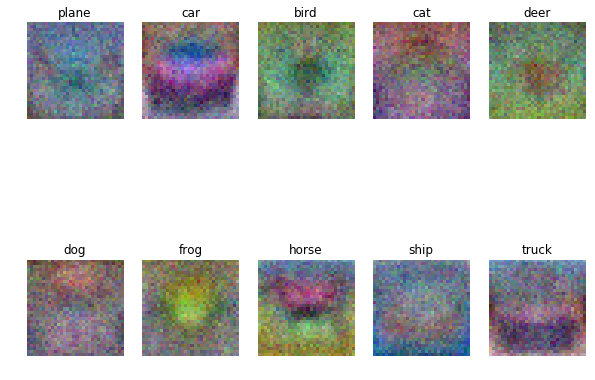

In [17]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])